# NDS Scalability & Spectral Heterodyning Comparison Experiment

This notebook implements a two-part experiment:

- **Part A** verifies O(m·T) linear scaling of NDS (Nonlinear Diffusion Signatures) preprocessing on synthetic Erdős–Rényi graphs and real benchmark graphs (CSL, MUTAG).
- **Part B** compares NDS (ReLU/tanh/abs nonlinearities), spectral heterodyning (pairwise Hadamard products of polynomial filter outputs), and a linear-only baseline across 5 initialization strategies on 1-WL-equivalent graph pairs.

**Key finding**: Degree init fails on all regular graphs (0/9 pairs distinguished); onehot/spectral/random inits distinguish all pairs with every method including the linear baseline; the nonlinearity in NDS does not provide additional distinguishing power beyond what multi-dimensional initialization already achieves.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT pre-installed on Colab, always install
_pip('loguru==0.7.3')

# numpy, scipy, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import gc
import json
import sys
import time
import tracemalloc

import numpy as np
from loguru import logger
from scipy import sparse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# ── Logging ──────────────────────────────────────────────────────────────────
logger.remove()
logger.add(
    sys.stdout,
    level="INFO",
    format="{time:HH:mm:ss}|{level:<7}|{message}",
)

1

## Data Loading

Load the mini demo dataset containing 1-WL-equivalent graph pairs and benchmark graphs from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter2_nds_scalability/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded demo data with keys: {list(data.keys())}")
print(f"1-WL pairs: {len(data['1wl_pairs']['examples'])} examples")
print(f"Benchmark datasets: {[ds['dataset'] for ds in data['benchmarks']['datasets']]}")

Loaded demo data with keys: ['metadata', '1wl_pairs', 'benchmarks']
1-WL pairs: 3 examples
Benchmark datasets: ['CSL', 'MUTAG']


## Configuration

All tunable parameters for both parts of the experiment.

In [5]:
# ── Part A: Scalability Config ──
SCALABILITY_SIZES = [100, 500, 1000, 5000, 10000, 50000]
SCALABILITY_AVG_DEGREE = 10
SCALABILITY_T = 10
SCALABILITY_N_REPEATS = 5
MAX_GRAPHS_PER_DS = 3  # Original: 20 (limited by demo data)

# ── Part B: Formulation Comparison Config ──
T_VALUES = [5, 10, 15, 20]
K_VALUES = [5, 10]
INIT_STRATEGIES = ["degree", "onehot", "local_structure", "spectral", "random_lowdim"]

## Core NDS Implementation

Graph adjacency builders and the Nonlinear Diffusion Signatures (NDS) computation — interleaving sparse matrix diffusion with element-wise nonlinearities (ReLU, tanh, abs).

In [6]:
def build_normalized_adjacency_from_edge_list(
    edge_list: list[list[int]],
    num_nodes: int,
) -> csr_matrix:
    """Build symmetric normalized adjacency D^{-1/2} A D^{-1/2} from edge list."""
    if not edge_list:
        return csr_matrix((num_nodes, num_nodes))
    rows, cols = [], []
    for u, v in edge_list:
        rows.extend([u, v])
        cols.extend([v, u])
    data = np.ones(len(rows), dtype=np.float64)
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))
    A = (A > 0).astype(np.float64)
    degrees = np.array(A.sum(axis=1)).flatten()
    deg_inv_sqrt = np.zeros(num_nodes)
    nonzero = degrees > 0
    deg_inv_sqrt[nonzero] = 1.0 / np.sqrt(degrees[nonzero])
    D_inv_sqrt = sparse.diags(deg_inv_sqrt)
    return D_inv_sqrt @ A @ D_inv_sqrt


def build_normalized_adjacency_from_dense(
    adj_matrix: list[list[int]],
) -> csr_matrix:
    """Build normalized adjacency from dense adjacency matrix (list-of-lists)."""
    A = csr_matrix(np.array(adj_matrix, dtype=np.float64))
    n = A.shape[0]
    degrees = np.array(A.sum(axis=1)).flatten()
    deg_inv_sqrt = np.zeros(n)
    nonzero = degrees > 0
    deg_inv_sqrt[nonzero] = 1.0 / np.sqrt(degrees[nonzero])
    D_inv_sqrt = sparse.diags(deg_inv_sqrt)
    return D_inv_sqrt @ A @ D_inv_sqrt


def build_normalized_adjacency_from_sparse(A: csr_matrix) -> csr_matrix:
    """Build normalized adjacency from an existing sparse adjacency matrix."""
    n = A.shape[0]
    degrees = np.array(A.sum(axis=1)).flatten()
    deg_inv_sqrt = np.zeros(n)
    nonzero = degrees > 0
    deg_inv_sqrt[nonzero] = 1.0 / np.sqrt(degrees[nonzero])
    D_inv_sqrt = sparse.diags(deg_inv_sqrt)
    return D_inv_sqrt @ A @ D_inv_sqrt


def compute_nds(
    A_norm: csr_matrix,
    X_init: np.ndarray,
    T: int,
    nonlinearity: str = "relu",
) -> np.ndarray:
    """Compute Nonlinear Diffusion Signatures.

    Supports both 1-D init (n,) and multi-D init (n, d).
    Returns trajectory of shape (n, (T+1)*d) for multi-D or (n, T+1) for 1-D.
    """
    if X_init.ndim == 1:
        X_init = X_init[:, np.newaxis]
    n, d = X_init.shape
    trajectory_cols: list[np.ndarray] = [X_init.copy()]
    X = X_init.copy()
    for _t in range(T):
        X = A_norm @ X
        if nonlinearity == "relu":
            X = np.maximum(X, 0.0)
        elif nonlinearity == "tanh":
            X = np.tanh(X)
        elif nonlinearity == "abs":
            X = np.abs(X)
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")
        trajectory_cols.append(X.copy())
    return np.hstack(trajectory_cols)

## Spectral Heterodyning & Linear Baseline

Spectral heterodyning forms all pairwise Hadamard products of polynomial filter outputs. The linear-only baseline (SIGN-like) applies diffusion without any nonlinearity.

In [7]:
def compute_polynomial_filters(
    A_norm: csr_matrix,
    X_init: np.ndarray,
    K: int,
) -> list[np.ndarray]:
    """Compute polynomial filter outputs: A^k * X_init for k=1..K."""
    outputs: list[np.ndarray] = []
    X = X_init.copy()
    for _k in range(K):
        X = A_norm @ X
        outputs.append(X.copy())
    return outputs


def compute_heterodyning_features(
    poly_outputs: list[np.ndarray],
) -> np.ndarray:
    """Form all pairwise Hadamard products p_i ⊙ p_j."""
    K = len(poly_outputs)
    features: list[np.ndarray] = []
    for i in range(K):
        for j in range(i, K):
            prod = poly_outputs[i] * poly_outputs[j]
            if prod.ndim == 1:
                prod = prod[:, np.newaxis]
            features.append(prod)
    return np.hstack(features)


def compute_linear_diffusion(
    A_norm: csr_matrix,
    X_init: np.ndarray,
    T: int,
) -> np.ndarray:
    """Linear diffusion only (no nonlinearity) — SIGN baseline."""
    if X_init.ndim == 1:
        X_init = X_init[:, np.newaxis]
    trajectory_cols: list[np.ndarray] = [X_init.copy()]
    X = X_init.copy()
    for _t in range(T):
        X = A_norm @ X
        trajectory_cols.append(X.copy())
    return np.hstack(trajectory_cols)

## Graph Distinguishing & Initialization Strategies

Checks if two graphs produce different sorted feature multisets. Five initialization strategies: degree, one-hot, local structure, spectral position encoding, and random low-dimensional.

In [8]:
def graphs_distinguished(
    feat1: np.ndarray,
    feat2: np.ndarray,
    tol: float = 1e-8,
) -> bool:
    """Check if two graphs produce different sorted feature multisets."""
    s1 = feat1[np.lexsort(feat1.T[::-1])]
    s2 = feat2[np.lexsort(feat2.T[::-1])]
    return not np.allclose(s1, s2, atol=tol)


def init_degree(A_norm: csr_matrix, n: int) -> np.ndarray:
    """Degree-based initialization (scalar per node)."""
    degrees = np.array((A_norm != 0).sum(axis=1)).flatten().astype(np.float64)
    return degrees


def init_onehot(n: int) -> np.ndarray:
    """One-hot initialization (identity matrix) — most expressive."""
    return np.eye(n, dtype=np.float64)


def init_random(n: int, seed: int = 42) -> np.ndarray:
    """Random initialization for reference."""
    rng = np.random.RandomState(seed)
    return rng.randn(n, 1)


def init_local_structure(A_norm: csr_matrix, n: int) -> np.ndarray:
    """Local structural init: [degree, triangle_count, clustering_coeff]."""
    A_bin = (A_norm != 0).astype(np.float64)
    degrees = np.array(A_bin.sum(axis=1)).flatten()
    A2 = A_bin @ A_bin
    A3_diag = np.array((A2.multiply(A_bin)).sum(axis=1)).flatten()
    triangles = A3_diag / 2.0
    clustering = np.zeros(n)
    nonzero_deg = degrees > 1
    clustering[nonzero_deg] = (
        2.0 * triangles[nonzero_deg]
        / (degrees[nonzero_deg] * (degrees[nonzero_deg] - 1))
    )
    return np.column_stack([degrees, triangles, clustering])


def init_spectral(A_norm: csr_matrix, n: int, k: int = 4) -> np.ndarray:
    """Spectral position encoding: top-k eigenvectors of normalized Laplacian."""
    from scipy.sparse.linalg import eigsh
    L = sparse.eye(n) - A_norm
    num_eigs = min(k + 1, n - 1)
    try:
        eigenvalues, eigenvectors = eigsh(L, k=num_eigs, which="SM")
    except Exception:
        L_dense = L.toarray()
        eigenvalues, eigenvectors = np.linalg.eigh(L_dense)
        eigenvalues = eigenvalues[:num_eigs]
        eigenvectors = eigenvectors[:, :num_eigs]
    return np.abs(eigenvectors[:, 1:k + 1]) if eigenvectors.shape[1] > 1 else np.abs(eigenvectors)


def init_random_lowdim(n: int, d: int = 4, seed: int = 42) -> np.ndarray:
    """Random d-dimensional initialization."""
    rng = np.random.RandomState(seed)
    return rng.randn(n, d)


def build_adjacency_and_init(
    graph_data: dict,
    init_strategy: str = "onehot",
) -> tuple[csr_matrix, np.ndarray]:
    """Build normalized adjacency and initial features from graph data."""
    n = graph_data["num_nodes"]
    if "adjacency_matrix" in graph_data:
        A_norm = build_normalized_adjacency_from_dense(graph_data["adjacency_matrix"])
    else:
        A_norm = build_normalized_adjacency_from_edge_list(
            graph_data["edge_list"], n
        )
    if init_strategy == "onehot":
        x_init = init_onehot(n)
    elif init_strategy == "degree":
        x_init = init_degree(A_norm, n)
    elif init_strategy == "random":
        x_init = init_random(n)
    elif init_strategy == "local_structure":
        x_init = init_local_structure(A_norm, n)
    elif init_strategy == "spectral":
        x_init = init_spectral(A_norm, n)
    elif init_strategy == "random_lowdim":
        x_init = init_random_lowdim(n)
    else:
        raise ValueError(f"Unknown init strategy: {init_strategy}")
    return A_norm, x_init

## Part A: Scalability Experiment

Generate synthetic Erdős–Rényi graphs of increasing size, time NDS preprocessing, and verify O(m·T) linear scaling via linear regression.

In [9]:
def run_scalability_experiment(
    sizes=None,
    avg_degree=SCALABILITY_AVG_DEGREE,
    T=SCALABILITY_T,
    n_repeats=SCALABILITY_N_REPEATS,
):
    """Measure NDS wall-clock time and peak memory vs graph size."""
    if sizes is None:
        sizes = SCALABILITY_SIZES

    results = []

    for n in sizes:
        logger.info(f"Scalability: n={n}")
        rng = np.random.RandomState(42)

        # Build ER graph as sparse adjacency
        m_target = int(n * avg_degree / 2)
        rows_raw = rng.randint(0, n, size=m_target * 3)
        cols_raw = rng.randint(0, n, size=m_target * 3)
        mask = rows_raw != cols_raw
        rows_raw, cols_raw = rows_raw[mask], cols_raw[mask]
        rows_raw = rows_raw[:m_target]
        cols_raw = cols_raw[:m_target]
        data_raw = np.ones(len(rows_raw))
        A = csr_matrix((data_raw, (rows_raw, cols_raw)), shape=(n, n))
        A = ((A + A.T) > 0).astype(np.float64)

        actual_m = A.nnz // 2
        A_norm = build_normalized_adjacency_from_sparse(A)
        x_init = np.array(A.sum(axis=1)).flatten()

        # Warmup
        _ = compute_nds(A_norm, x_init, T)

        # Timed runs
        times = []
        peak_mems = []
        for _rep in range(n_repeats):
            tracemalloc.start()
            t0 = time.perf_counter()
            _ = compute_nds(A_norm, x_init, T)
            t1 = time.perf_counter()
            _current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            times.append(t1 - t0)
            peak_mems.append(peak / (1024 * 1024))

        median_time = float(np.median(times))
        median_mem = float(np.median(peak_mems))
        results.append({
            "n": n, "m": actual_m, "mT": actual_m * T,
            "time_sec": median_time, "peak_memory_MB": median_mem, "T": T,
            "all_times": [round(t, 6) for t in times],
        })
        logger.info(f"  n={n}, m={actual_m}, mT={actual_m*T}, time={median_time:.5f}s, mem={median_mem:.1f}MB")
        gc.collect()

    # Linear regression: time vs m*T
    mT_vals = np.array([r["mT"] for r in results], dtype=np.float64)
    time_vals = np.array([r["time_sec"] for r in results], dtype=np.float64)
    A_reg = np.vstack([mT_vals, np.ones(len(mT_vals))]).T
    coeffs, residuals, rank, sv = np.linalg.lstsq(A_reg, time_vals, rcond=None)
    slope, intercept = coeffs
    ss_res = float(np.sum((time_vals - (slope * mT_vals + intercept)) ** 2))
    ss_tot = float(np.sum((time_vals - np.mean(time_vals)) ** 2))
    r_squared = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

    logger.info(f"Scalability linear fit: R²={r_squared:.4f}, slope={slope:.2e}")
    return results, r_squared, slope

scale_results, r_squared, slope = run_scalability_experiment()
print(f"\nR² = {r_squared:.4f}, slope = {slope:.2e}")

23:37:00|INFO   |Scalability: n=100


23:37:00|INFO   |  n=100, m=478, mT=4780, time=0.00022s, mem=0.0MB


23:37:00|INFO   |Scalability: n=500


23:37:00|INFO   |  n=500, m=2481, mT=24810, time=0.00031s, mem=0.1MB


23:37:00|INFO   |Scalability: n=1000


23:37:00|INFO   |  n=1000, m=4973, mT=49730, time=0.00033s, mem=0.2MB


23:37:00|INFO   |Scalability: n=5000


23:37:00|INFO   |  n=5000, m=24971, mT=249710, time=0.00132s, mem=0.9MB


23:37:00|INFO   |Scalability: n=10000


23:37:00|INFO   |  n=10000, m=49984, mT=499840, time=0.00376s, mem=1.8MB


23:37:00|INFO   |Scalability: n=50000


23:37:00|INFO   |  n=50000, m=249984, mT=2499840, time=0.01593s, mem=8.8MB


23:37:00|INFO   |Scalability linear fit: R²=0.9979, slope=6.34e-09



R² = 0.9979, slope = 6.34e-09


## Part A: Benchmark Timing

Time NDS on real benchmark graphs (CSL, MUTAG) from the loaded demo data.

In [10]:
def run_benchmark_timing(
    benchmark_data,
    T=SCALABILITY_T,
    max_graphs_per_ds=MAX_GRAPHS_PER_DS,
):
    """Time NDS on real benchmark graphs."""
    results_per_dataset = {}

    for ds in benchmark_data["datasets"]:
        ds_name = ds["dataset"]
        if ds_name.endswith("_mini"):
            continue
        times = []
        n_nodes_list = []
        n_edges_list = []
        examples = ds["examples"][:max_graphs_per_ds]
        for ex in examples:
            graph = json.loads(ex["input"])
            edge_list = graph["edge_list"]
            num_nodes = graph["num_nodes"]
            A_norm = build_normalized_adjacency_from_edge_list(edge_list, num_nodes)
            x_init = init_degree(A_norm, num_nodes)

            t0 = time.perf_counter()
            _ = compute_nds(A_norm, x_init, T)
            t1 = time.perf_counter()
            times.append(t1 - t0)
            n_nodes_list.append(num_nodes)
            n_edges_list.append(len(edge_list) // 2)

        results_per_dataset[ds_name] = {
            "mean_time": float(np.mean(times)),
            "max_time": float(np.max(times)),
            "std_time": float(np.std(times)),
            "num_graphs": len(times),
            "avg_nodes": float(np.mean(n_nodes_list)),
            "avg_edges": float(np.mean(n_edges_list)),
        }
        logger.info(
            f"Benchmark {ds_name}: {len(times)} graphs, "
            f"mean={np.mean(times):.5f}s, max={np.max(times):.5f}s"
        )
    return results_per_dataset

bench_timing = run_benchmark_timing(data["benchmarks"])
for ds_name, stats in bench_timing.items():
    print(f"{ds_name}: {stats['num_graphs']} graphs, mean_time={stats['mean_time']:.6f}s")

23:37:00|INFO   |Benchmark CSL: 3 graphs, mean=0.00010s, max=0.00011s


23:37:00|INFO   |Benchmark MUTAG: 3 graphs, mean=0.00009s, max=0.00010s


CSL: 3 graphs, mean_time=0.000097s
MUTAG: 3 graphs, mean_time=0.000091s


## Part B: Formulation Comparison on 1-WL-Equivalent Pairs

Compare NDS (ReLU/tanh/abs), spectral heterodyning, and linear baseline across 5 initialization strategies on graph pairs that are provably indistinguishable by 1-WL.

In [11]:
def parse_graph_pair(example):
    """Parse a 1-WL pair example into (pair_info, graph_a_data, graph_b_data)."""
    pair_info = json.loads(example["input"])
    graph_a = pair_info["graph_a"]
    graph_b = pair_info["graph_b"]
    return pair_info, graph_a, graph_b


def run_formulation_comparison(
    pairs_data,
    T_values=None,
    K_values=None,
):
    """Compare NDS vs spectral heterodyning on 1-WL-equivalent pairs."""
    if T_values is None:
        T_values = T_VALUES
    if K_values is None:
        K_values = K_VALUES

    results = []

    for pair_idx, ex in enumerate(pairs_data):
        pair_info, graph_a, graph_b = parse_graph_pair(ex)
        pair_id = pair_info["pair_id"]
        category = pair_info["category"]
        n = graph_a["num_nodes"]
        logger.info(f"Pair {pair_idx}: {pair_id} (n={n}, cat={category})")

        pair_result = {
            "pair_idx": pair_idx, "pair_id": pair_id,
            "category": category, "n": n,
        }

        for init_strat in INIT_STRATEGIES:
            A1_norm, x1 = build_adjacency_and_init(graph_a, init_strategy=init_strat)
            A2_norm, x2 = build_adjacency_and_init(graph_b, init_strategy=init_strat)
            prefix = init_strat

            # Linear baseline
            for T in T_values:
                t0 = time.perf_counter()
                lin1 = compute_linear_diffusion(A1_norm, x1, T)
                lin2 = compute_linear_diffusion(A2_norm, x2, T)
                t1 = time.perf_counter()
                dist = graphs_distinguished(lin1, lin2)
                pair_result[f"{prefix}_linear_T{T}_distinguished"] = dist
                pair_result[f"{prefix}_linear_T{T}_time"] = round(t1 - t0, 6)

            # NDS with ReLU
            for T in T_values:
                t0 = time.perf_counter()
                nds1 = compute_nds(A1_norm, x1, T, "relu")
                nds2 = compute_nds(A2_norm, x2, T, "relu")
                t1 = time.perf_counter()
                dist = graphs_distinguished(nds1, nds2)
                pair_result[f"{prefix}_nds_relu_T{T}_distinguished"] = dist
                pair_result[f"{prefix}_nds_relu_T{T}_time"] = round(t1 - t0, 6)

            # NDS with tanh
            for T in T_values:
                t0 = time.perf_counter()
                nds1 = compute_nds(A1_norm, x1, T, "tanh")
                nds2 = compute_nds(A2_norm, x2, T, "tanh")
                t1 = time.perf_counter()
                dist = graphs_distinguished(nds1, nds2)
                pair_result[f"{prefix}_nds_tanh_T{T}_distinguished"] = dist
                pair_result[f"{prefix}_nds_tanh_T{T}_time"] = round(t1 - t0, 6)

            # NDS with abs
            for T in T_values:
                t0 = time.perf_counter()
                nds1 = compute_nds(A1_norm, x1, T, "abs")
                nds2 = compute_nds(A2_norm, x2, T, "abs")
                t1 = time.perf_counter()
                dist = graphs_distinguished(nds1, nds2)
                pair_result[f"{prefix}_nds_abs_T{T}_distinguished"] = dist
                pair_result[f"{prefix}_nds_abs_T{T}_time"] = round(t1 - t0, 6)

            # Spectral heterodyning
            for K in K_values:
                t0 = time.perf_counter()
                poly1 = compute_polynomial_filters(A1_norm, x1, K)
                het1 = compute_heterodyning_features(poly1)
                poly2 = compute_polynomial_filters(A2_norm, x2, K)
                het2 = compute_heterodyning_features(poly2)
                t1 = time.perf_counter()
                dist = graphs_distinguished(het1, het2)
                pair_result[f"{prefix}_hetero_K{K}_distinguished"] = dist
                pair_result[f"{prefix}_hetero_K{K}_time"] = round(t1 - t0, 6)

        results.append(pair_result)

    return results

all_pairs = data["1wl_pairs"]["examples"]
comparison_results = run_formulation_comparison(
    all_pairs,
    T_values=T_VALUES,
    K_values=K_VALUES,
)
print(f"Processed {len(comparison_results)} graph pairs")

23:37:00|INFO   |Pair 0: srg16_rook_vs_shrikhande (n=16, cat=srg_16_6_2_2)


23:37:01|INFO   |Pair 1: srg25_paulus_g1_vs_g2 (n=25, cat=srg_25_12_5_6)


23:37:01|INFO   |Pair 2: srg25_paulus_g1_vs_g3 (n=25, cat=srg_25_12_5_6)


Processed 3 graph pairs


## Aggregation & Summary

Count how many 1-WL pairs each method distinguishes across all initialization strategies and diffusion steps.

In [12]:
def aggregate_distinguishing_power(
    comparison_results,
    T_values=None,
    K_values=None,
):
    """Count how many pairs each method distinguishes."""
    if T_values is None:
        T_values = T_VALUES
    if K_values is None:
        K_values = K_VALUES

    total = len(comparison_results)
    summary = {"total_pairs": total}

    for init_strat in INIT_STRATEGIES:
        prefix = init_strat
        for T in T_values:
            key = f"{prefix}_linear_T{T}"
            count = sum(
                1 for r in comparison_results if r.get(f"{key}_distinguished", False)
            )
            summary[f"{key}_count"] = count

        for nl in ["relu", "tanh", "abs"]:
            for T in T_values:
                key = f"{prefix}_nds_{nl}_T{T}"
                count = sum(
                    1 for r in comparison_results
                    if r.get(f"{key}_distinguished", False)
                )
                summary[f"{key}_count"] = count

        for K in K_values:
            key = f"{prefix}_hetero_K{K}"
            count = sum(
                1 for r in comparison_results if r.get(f"{key}_distinguished", False)
            )
            summary[f"{key}_count"] = count

    return summary

summary = aggregate_distinguishing_power(
    comparison_results,
    T_values=T_VALUES,
    K_values=K_VALUES,
)
print(f"Total pairs: {summary['total_pairs']}")
for k, v in sorted(summary.items()):
    if k != "total_pairs":
        print(f"  {k}: {v}/{summary['total_pairs']}")

Total pairs: 3
  degree_hetero_K10_count: 0/3
  degree_hetero_K5_count: 0/3
  degree_linear_T10_count: 0/3
  degree_linear_T15_count: 0/3
  degree_linear_T20_count: 0/3
  degree_linear_T5_count: 0/3
  degree_nds_abs_T10_count: 0/3
  degree_nds_abs_T15_count: 0/3
  degree_nds_abs_T20_count: 0/3
  degree_nds_abs_T5_count: 0/3
  degree_nds_relu_T10_count: 0/3
  degree_nds_relu_T15_count: 0/3
  degree_nds_relu_T20_count: 0/3
  degree_nds_relu_T5_count: 0/3
  degree_nds_tanh_T10_count: 0/3
  degree_nds_tanh_T15_count: 0/3
  degree_nds_tanh_T20_count: 0/3
  degree_nds_tanh_T5_count: 0/3
  local_structure_hetero_K10_count: 0/3
  local_structure_hetero_K5_count: 0/3
  local_structure_linear_T10_count: 0/3
  local_structure_linear_T15_count: 0/3
  local_structure_linear_T20_count: 0/3
  local_structure_linear_T5_count: 0/3
  local_structure_nds_abs_T10_count: 0/3
  local_structure_nds_abs_T15_count: 0/3
  local_structure_nds_abs_T20_count: 0/3
  local_structure_nds_abs_T5_count: 0/3
  local_str

## Visualization

**Left**: NDS time vs m·T with linear fit (Part A scalability).
**Right**: Distinguishing power heatmap — rows are init strategies, columns are methods (Part B).

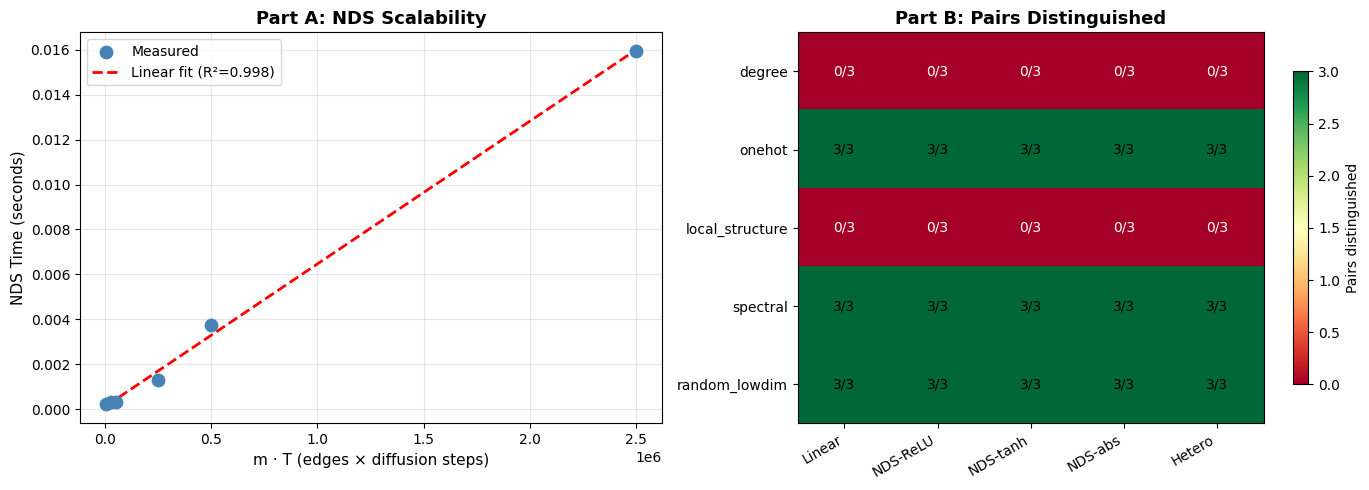

Saved results_plot.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Plot 1: Scalability (time vs m·T) ──
ax1 = axes[0]
mT_vals = [r["mT"] for r in scale_results]
time_vals = [r["time_sec"] for r in scale_results]
ax1.scatter(mT_vals, time_vals, color="steelblue", s=80, zorder=5, label="Measured")
# Linear fit line
mT_arr = np.array(mT_vals)
fit_line = slope * mT_arr + (np.mean(time_vals) - slope * np.mean(mT_vals))
ax1.plot(mT_arr, fit_line, "r--", linewidth=2, label=f"Linear fit (R²={r_squared:.3f})")
ax1.set_xlabel("m · T (edges × diffusion steps)", fontsize=11)
ax1.set_ylabel("NDS Time (seconds)", fontsize=11)
ax1.set_title("Part A: NDS Scalability", fontsize=13, fontweight="bold")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ── Plot 2: Distinguishing power heatmap ──
ax2 = axes[1]
total = summary["total_pairs"]
# Build heatmap: rows = init strategies, cols = methods
methods = ["linear", "nds_relu", "nds_tanh", "nds_abs", "hetero"]
method_labels = ["Linear", "NDS-ReLU", "NDS-tanh", "NDS-abs", "Hetero"]
init_labels = INIT_STRATEGIES

heatmap_data = []
for init_strat in init_labels:
    row = []
    for method in methods:
        if method == "hetero":
            key = f"{init_strat}_{method}_K{K_VALUES[0]}_count"
        else:
            key = f"{init_strat}_{method}_T{T_VALUES[0]}_count"
        row.append(summary.get(key, 0))
    heatmap_data.append(row)

heatmap_arr = np.array(heatmap_data)
im = ax2.imshow(heatmap_arr, cmap="RdYlGn", vmin=0, vmax=total, aspect="auto")

# Annotations
for i in range(len(init_labels)):
    for j in range(len(methods)):
        val = heatmap_arr[i, j]
        ax2.text(j, i, f"{int(val)}/{total}",
                 ha="center", va="center", fontsize=10,
                 color="white" if val < total / 2 else "black")

ax2.set_xticks(range(len(method_labels)))
ax2.set_xticklabels(method_labels, fontsize=10, rotation=30, ha="right")
ax2.set_yticks(range(len(init_labels)))
ax2.set_yticklabels(init_labels, fontsize=10)
ax2.set_title("Part B: Pairs Distinguished", fontsize=13, fontweight="bold")
fig.colorbar(im, ax=ax2, shrink=0.8, label="Pairs distinguished")

plt.tight_layout()
plt.savefig("results_plot.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved results_plot.png")